<a href="https://colab.research.google.com/github/adammoss/bnn_hmc/blob/main/results/Mirabest_MCD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
import numpy as np
import os
import astro_datasets
import tensorflow_datasets as tfds
from matplotlib import pyplot as plt
import seaborn as sns

In [2]:
samples_iter = 200
dropout = 0.1

In [3]:
!pip install astro-datasets --upgrade

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
!pip install tensorflow_datasets --upgrade

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Load dataset, splitting into training, validation and testing

In [5]:
dataset_train, info_train = tfds.load(name='mirabest/confident', split='train[:80%]', batch_size=50, as_supervised=True, with_info=True)
dataset_valid, info_valid = tfds.load(name='mirabest/confident', split='train[80%:]', batch_size=50, as_supervised=True, with_info=True) 
dataset_test, info_test = tfds.load(name='mirabest/confident', split='test', batch_size=50, as_supervised=True, with_info=True) 

Define MCD layer

In [6]:
class MonteCarloDropout(tf.keras.layers.Dropout):
     def call(self, inputs):
         return super().call(inputs, training=True)

Create model

In [7]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(6, kernel_size=5, strides=1, padding = 'same', input_shape=(150, 150, 1)),
    tf.keras.layers.ReLU(),
    tf.keras.layers.MaxPool2D(pool_size=(3, 3), strides=(2,2)),
    MonteCarloDropout(dropout),
    tf.keras.layers.Conv2D(16, kernel_size=5, strides=1, padding = 'same'),
    tf.keras.layers.ReLU(),
    tf.keras.layers.MaxPool2D(pool_size=(3, 3), strides=(2,2)),
    MonteCarloDropout(dropout),
    tf.keras.layers.Conv2D(120, kernel_size=5, strides=1, padding = 'same'),
    tf.keras.layers.ReLU(),
    tf.keras.layers.MaxPool2D(pool_size=(3, 3), strides=(2,2)),
    MonteCarloDropout(dropout),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(84),
    tf.keras.layers.ReLU(),
    MonteCarloDropout(dropout),
    tf.keras.layers.Dense(2, activation='softmax'),
    ])

In [8]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 150, 150, 6)       156       
                                                                 
 re_lu (ReLU)                (None, 150, 150, 6)       0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 74, 74, 6)        0         
 )                                                               
                                                                 
 monte_carlo_dropout (MonteC  (None, 74, 74, 6)        0         
 arloDropout)                                                    
                                                                 
 conv2d_1 (Conv2D)           (None, 74, 74, 16)        2416      
                                                                 
 re_lu_1 (ReLU)              (None, 74, 74, 16)        0

Loss function

In [9]:
loss=tf.keras.losses.SparseCategoricalCrossentropy()

Optimiser and learning rate scheduler

In [10]:
opt = tf.keras.optimizers.Adam(learning_rate=5e-5)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.95, patience=3)

Compile model

In [11]:
model.compile(optimizer=opt,
              loss=loss,
              metrics='accuracy')


Save best weights

In [12]:
checkpoint_path = "mirabest/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                  save_weights_only=False,
                                                  monitor='val_loss',
                                                  mode='min',
                                                  verbose=1,
                                                  save_best_only=True)

Train model

In [13]:
model.fit(dataset_train, epochs=100, callbacks=[reduce_lr, cp_callback], validation_data=dataset_valid)

Epoch 1/100
12/12 [==============================] - ETA: 0s - loss: 1.7499 - accuracy: 0.5077
Epoch 1: val_loss improved from inf to 1.10516, saving model to mirabest/cp.ckpt
12/12 [==============================] - 6s 274ms/step - loss: 1.7499 - accuracy: 0.5077 - val_loss: 1.1052 - val_accuracy: 0.5274 - lr: 5.0000e-05
Epoch 2/100
10/12 [========================>.....] - ETA: 0s - loss: 0.8319 - accuracy: 0.6480
Epoch 2: val_loss improved from 1.10516 to 0.73141, saving model to mirabest/cp.ckpt
12/12 [==============================] - 3s 264ms/step - loss: 0.8127 - accuracy: 0.6449 - val_loss: 0.7314 - val_accuracy: 0.6301 - lr: 5.0000e-05
Epoch 3/100
 9/12 [=====================>........] - ETA: 0s - loss: 0.5650 - accuracy: 0.7400
Epoch 3: val_loss improved from 0.73141 to 0.70089, saving model to mirabest/cp.ckpt
12/12 [==============================] - 3s 293ms/step - loss: 0.5401 - accuracy: 0.7410 - val_loss: 0.7009 - val_accuracy: 0.6438 - lr: 5.0000e-05
Epoch 4/100
 7/12 [=

Test model

In [14]:
new_model = tf.keras.models.load_model('mirabest/cp.ckpt')

In [15]:
softmax = []
accuracies = []
for _ in range(samples_iter):
  correct, n = 0, 0
  s = []
  for (x, y) in dataset_test:
    yhat = new_model.predict(x)
    correct += np.sum(np.argmax(yhat, axis=-1) == y)
    n += len(y)
    s.append(yhat)
  s = np.concatenate(s)
  softmax.append(s)
  accuracies.append(correct / n)
  print('Accuracy:',correct / n)
softmax = np.array(softmax)

Accuracy: 0.7884615384615384
Accuracy: 0.8173076923076923
Accuracy: 0.8846153846153846
Accuracy: 0.8173076923076923
Accuracy: 0.8557692307692307
Accuracy: 0.8269230769230769
Accuracy: 0.8365384615384616
Accuracy: 0.8365384615384616
Accuracy: 0.7884615384615384
Accuracy: 0.8365384615384616
Accuracy: 0.8076923076923077
Accuracy: 0.7692307692307693
Accuracy: 0.8461538461538461
Accuracy: 0.7980769230769231
Accuracy: 0.8173076923076923
Accuracy: 0.8173076923076923
Accuracy: 0.8461538461538461
Accuracy: 0.7692307692307693
Accuracy: 0.7884615384615384
Accuracy: 0.8173076923076923
Accuracy: 0.8076923076923077
Accuracy: 0.8365384615384616
Accuracy: 0.8173076923076923
Accuracy: 0.8076923076923077
Accuracy: 0.8557692307692307
Accuracy: 0.8365384615384616
Accuracy: 0.8173076923076923
Accuracy: 0.7884615384615384
Accuracy: 0.8173076923076923
Accuracy: 0.8076923076923077
Accuracy: 0.7788461538461539
Accuracy: 0.7692307692307693
Accuracy: 0.8461538461538461
Accuracy: 0.7884615384615384
Accuracy: 0.81

In [16]:
print('Accuracy', np.mean(accuracies), np.std(accuracies))

Accuracy 0.8057211538461538 0.023102900042735217


In [17]:
def uncertainty(softmax):
  # Per example softmax with shape(num_examples, num_classes)
  predictive_entropy = 0
  single_pass_entropy = 0
  for i in range(softmax.shape[1]):
    # Sum over classes
    predictive_entropy += -np.mean(softmax[:,i])*np.log(np.mean(softmax[:,i]))
    single_pass_entropy += -softmax[:,i]*np.log(softmax[:,i])
  single_pass_entropy = np.mean(single_pass_entropy)
  mutual_info = predictive_entropy - single_pass_entropy
  return predictive_entropy, single_pass_entropy, mutual_info

In [18]:
predictive_entropies = [] 
single_pass_entropies = []
mutual_infos = []
for i in range(softmax.shape[1]):
  predictive_entropy, single_pass_entropy, mutual_info = uncertainty(softmax[:,i,:])
  predictive_entropies.append(predictive_entropy)
  single_pass_entropies.append(single_pass_entropy)
  mutual_infos.append(mutual_info)
print('Predictive entropy:', np.mean(predictive_entropies), np.std(predictive_entropies))
print('Single pass entropy:', np.mean(single_pass_entropies), np.std(single_pass_entropies))
print('Mutual info:', np.mean(mutual_infos), np.std(mutual_infos))

Predictive entropy: 0.30058785614498074 0.22516945937230232
Single pass entropy: 0.22893868 0.17530042
Mutual info: 0.07164919167428689 0.06090488705126512


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


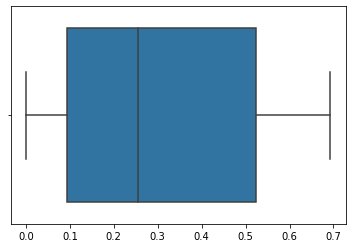

In [19]:
sns.boxplot(predictive_entropies)
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


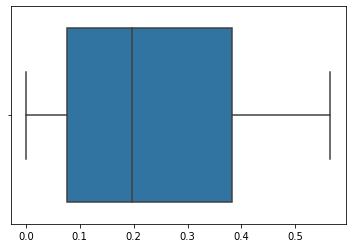

In [20]:
sns.boxplot(single_pass_entropies)
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


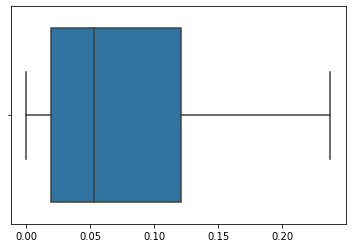

In [21]:
sns.boxplot(mutual_infos)
plt.show()